# Import python dataset

In [1]:
k = 21

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [28]:
from __future__ import print_function, division
import tensorflow as tf
import tensorflow.keras.backend as backend
from tensorflow import reduce_mean
import keras
from keras import losses, backend
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.models import Sequential, Model
from keras.constraints import Constraint

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import *
import functools
import time
import gc
from keras.initializers import RandomNormal
import joblib
import matplotlib.ticker as mticker


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()

In [4]:
os.makedirs('./output/Figures/Prediction/New')
os.makedirs('./output/Figures/Individual')
os.makedirs('./output/Figures/Result')
os.makedirs('./output/Figures/Loss')
os.makedirs('./output/Figures/Different_Field/New')
os.makedirs('./content')

## Load data

In [5]:
notebookName = 'AAE-NEW_'

In [6]:
n_features = 7

In [26]:
data= np.loadtxt('../input/pollutant/01.txt') 
print(data.shape)

data02= np.loadtxt('../input/pollutant/02.txt') 
print(data02.shape)

data04= np.loadtxt('../input/pollutant/04.txt') 
print(data04.shape)


groups = ['PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups = np.array(groups)
print(groups.shape)

groups2 = ['times','PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups2 = np.array(groups2)
print(groups2.shape)

with open("../input/pollutant/10_2_time.csv", "r", encoding="utf-8") as fr:
    times = [fr.readlines()]
    
times = np.array(times)
times = times.T

print('times = ',times[:,0].shape)
print(times[0,:])

(1419, 7)
(1419, 7)
(1419, 7)
(6,)
(7,)
times =  (1419,)
['00:10\n']


# Preparing Dataset

In [8]:
codings_size = n_features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[-1,1])
X_train_scaled = scaler.fit_transform(data)

X_train_scaled.shape 


(1419, 7)

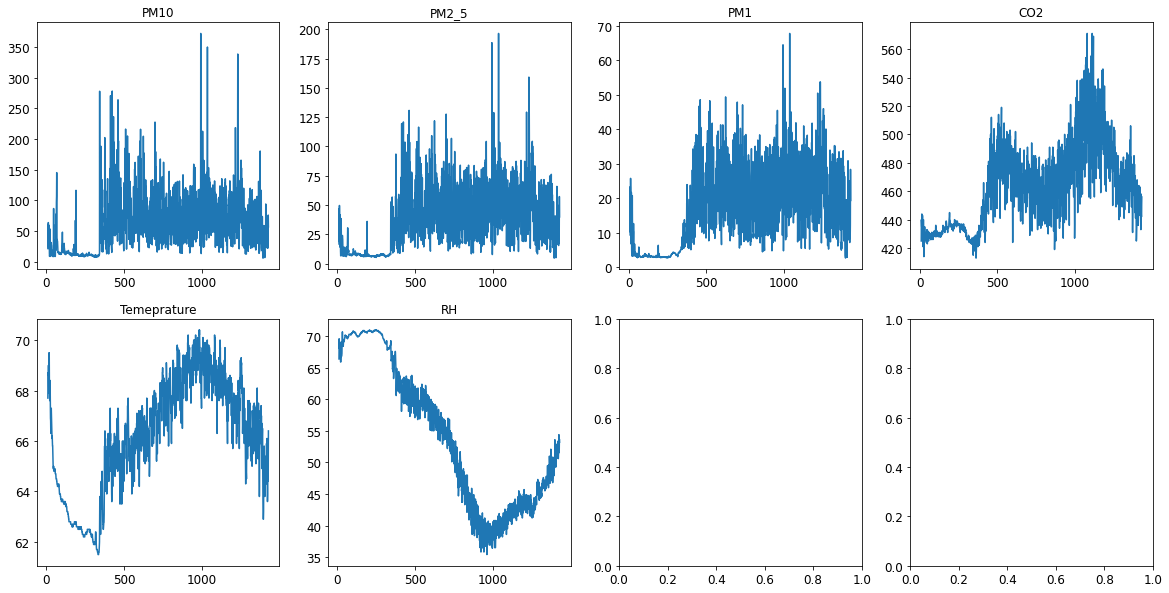

In [9]:
#scaler inverse_transform
X_train = scaler.inverse_transform(((X_train_scaled)))
X_train.shape 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #a=i+1
    ax.flatten()[i].plot(X_train[:,0], X_train[:,i+1])
    ax.flatten()[i].set_title(group)
plt.savefig('./output/Figures/Individual/Sample'+'_v'+str(k)+'.png')

# Train the GAN

### Preparing the training dataset

In [10]:
n = 500

(1319, 100, 7, 1)


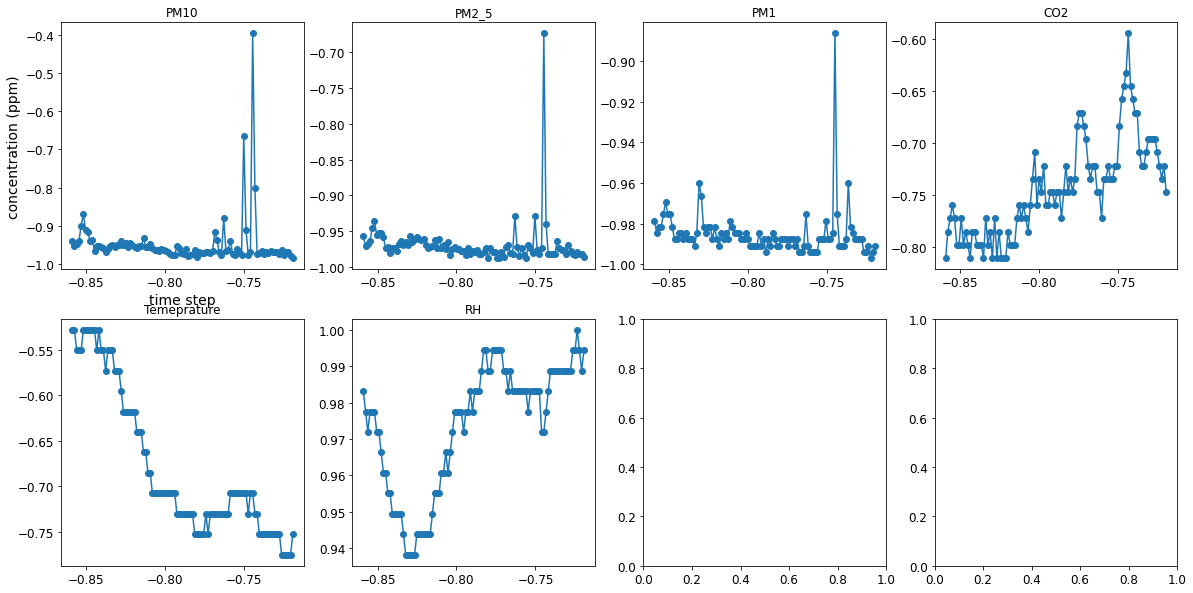

In [11]:
def concat_timesteps(X_train_scaled, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train_scaled) - ntimes*step):
        X_train_concat.append(X_train_scaled[i:i+ntimes*step:step])
    return np.array(X_train_concat)

ntimes = 100 # Consecutive times for the GAN
step = 1 # step between times (1 mins)

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)#X_train_scaled
X_train_concat = X_train_concat.reshape(X_train_concat.shape[0],ntimes,n_features,1)
print(X_train_concat.shape)




#Individual sample dataset
n = 100
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_concat[n,:,0], X_train_concat[n,:,i+1], '-o')
    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")
    

In [12]:
BATCH_SIZE = 256
latent_space = 50

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.astype('float32').reshape(X_train_concat.shape[0], ntimes, n_features, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_scaled))
train_dataset = train_dataset.batch(BATCH_SIZE)

for data in train_dataset:
    print(data.shape)
    break

(256, 100, 7, 1)


### Building model

In [14]:
import tensorflow.keras.backend as backend
from keras import Input, Model
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise ,Conv1DTranspose
from keras.layers.convolutional import UpSampling2D,UpSampling1D, Conv2D,Conv1D,Conv2DTranspose


from keras.layers import merge, Lambda
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as backend
from keras.constraints import Constraint
from keras.initializers import RandomNormal

In [ ]:
constraint = 10

class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(clip_value):
        clip_value = clip_value

    # clip model weights to hypercube
    def __call__( weights):
        return backend.clip(weights, -clip_value, clip_value)

    # get the config
    def get_config():
        return {'clip_value': clip_value}
    
    
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [ ]:
def make_encoder_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(16, (1, 1), strides=(1, 1), padding='same', input_shape=[ntimes, n_features, 1]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(8, (1, 1), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(4, (1, 1), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(latent_space))
    return model

encoder = make_encoder_model()
encoder.summary()



def make_decoder_model():
    model = tf.keras.Sequential()
    
    model.add(keras.layers.Dense(50*4*256, use_bias=False, input_shape=(latent_space,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Reshape((50, 4, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', output_padding=[0,0], use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))
    
    model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', output_padding=[1,0], use_bias=False, activation='tanh'))

    return model

decoder = make_decoder_model()
decoder.summary()

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(keras.layers.Dense(50*4*256, use_bias=False, input_shape=(latent_space,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Reshape((50, 4, 256)))
    
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Conv2D(128, (3, 3), strides=(1, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    return model

discriminator = make_discriminator_model()
discriminator.summary()



#discriminator.trainable = False

In [ ]:
ae = keras.models.Sequential([encoder, decoder])
enc_disc = keras.models.Sequential([encoder, discriminator])

# Define Training 

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

def compute_reconstruction_loss(x, x_logit):
    reconstruction_loss = mse(x, x_logit)
    return reconstruction_loss

def compute_discriminator_loss(fake_output, real_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def compute_generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

reconstruction_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

# The discriminator and the generator optimizers are different since we will train two networks separately.
r_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


# logs to follow losses on tensorboard
reconstrunction_log_dir = './logs/AAE_NEW/reconstrunction'
generator_log_dir = './logs/AAE_NEW/generator'
discriminator_log_dir = './logs/AAE_NEW/AAE_NEW//discriminator'

# Creates a summary file writer for the given log directory
reconstrunction_summary_writer = tf.summary.create_file_writer(reconstrunction_log_dir)
generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    # Autoencoder update
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch, training=True)
        decoder_output = decoder(encoder_output, training=True)
        reconstruction_loss = compute_reconstruction_loss(batch, decoder_output)

    r_gradients = ae_tape.gradient(reconstruction_loss, encoder.trainable_variables + decoder.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, encoder.trainable_variables + decoder.trainable_variables))

    # Discriminator update
    with tf.GradientTape() as d_tape:
        z = encoder(batch, training=True)
        true_z = tf.random.normal(shape=(z.shape))
        fake_output = discriminator(z, training=True)
        true_output = discriminator(true_z, training=True)
        discriminator_loss = compute_discriminator_loss(fake_output, true_output)
    d_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    for _ in range(2):
    # Generator update
        with tf.GradientTape() as g_tape:
            z = encoder(batch, training=True)
            fake_output = discriminator(z, training=True)
            generator_loss = compute_generator_loss(fake_output)
        g_gradients = g_tape.gradient(generator_loss, encoder.trainable_variables)
        g_optimizer.apply_gradients(zip(g_gradients, encoder.trainable_variables))

    reconstruction_mean_loss(reconstruction_loss)
    generator_mean_loss(generator_loss)
    discriminator_mean_loss(discriminator_loss)

In [ ]:
GANorWGAN = 'GAN'

c1_hist = []
c2_hist = []
g1_hist = []
g2_hist = []
        
lr_start = 0.0001 
lr_mid = 0.0001 
lr_end = 0.0001

In [ ]:
def generated_data(latent_space, X_train_concat, ntimes, n_features, groups, epoch):
    #n_instances = 100
    #noise = tf.random.normal([n_instances, latent_space])
    generated_image = decoder(encoder(X_train_concat, training=False))
    print(generated_image.shape)

    generated_image = generated_image.numpy()
    generated_image = generated_image.reshape(X_train_concat.shape[0]*ntimes, n_features)
    generated_image = scaler.inverse_transform(generated_image)

    fig, ax = plt.subplots(2,4, figsize=[20,10])

    for i, group in enumerate(groups):
        ax.flatten()[i].plot(generated_image[:,0],generated_image[:,i+1],'o',c='orange')
        ax.flatten()[i].set_title(group)
        ax.flatten()[0].set_xlabel("time step")
        ax.flatten()[0].set_ylabel("concentration (ppm)")
    
    plt.savefig('./output/Figures/Result/AAE_NEW_result_v'+str(k)+'_epoch_'+str(epoch+1)+'.png')
    plt.show()
    
    print('save generated image')

    
def plot_loss(epoch,c1_hist,c2_hist,g1_hist,g2_hist):
    
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.plot(c1_hist)
    plt.plot(c2_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Discriminator Loss")
    plt.legend(['C real', 'C fake'])

    plt.subplot(1,2,2)
    plt.plot(g1_hist)
    plt.plot(g2_hist, c='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Discriminator','Decoder'])
    plt.title('Encoder Loss')
    
    plt.savefig('./output/Figures/Loss/loss_v'+str(k)+'_epoch_'+str(epoch+1)+'.png')
    plt.show()

In [ ]:
def train(dataset, epochs):
    hist = []
    reconstruction = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch + 1, epochs))   
        for batch in dataset:
            train_step(batch)
        '''
        with generator_summary_writer.as_default():
        # Write a scalar summary
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        with discriminator_summary_writer.as_default():
            tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)

        with reconstrunction_summary_writer.as_default():
            tf.summary.scalar('loss', reconstruction_mean_loss.result(), step=epoch)
        '''
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])
        reconstruction.append(reconstruction_mean_loss.result().numpy())

        # Resets all of the metric state variables.
        # This function is called between epochs/steps, when a metric is evaluated during training.
        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        reconstruction_mean_loss.reset_states()
        
        if (epoch+1) %5000 == 0:
            #wgan.save('ganmodels/'+notebookName[:-6]+'_v'+str(k)+'_epoch_'+str(epoch+1)+'.h5')   
            ae.save('./content/aeAAE-New'+str(k)+str(epoch)+'.h5')
            enc_disc.save('./content/enc-AAE-New'+str(k)+str(epoch)+'.h5')

            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            ax.grid()
            plt.savefig('./output/Figures/Loss/AAE-New_loss_v'+str(k)+'_epoch_'+str(epoch+1)+'.png')
            plt.show()
            
            
            generated_data(latent_space, X_train_concat, ntimes, n_features, groups, epoch)
            
            
         
    return hist, reconstruction

# Formally Training

In [ ]:
epochs = 10000

In [ ]:
#hist = train(train_dataset, epochs)#55000

In [ ]:
k = k
epoch= epochs

# Load Model

In [15]:
from tensorflow.keras.models import load_model
import joblib
#dcgan = keras.models.load_model('ganmodels/Tube-timestep.prediction_v8033_epoch_50000.h5')
ae = keras.models.load_model('../input/ganmodels/ae10000.h5').layers
encoder, decoder = load_model('../input/ganmodels/ae10000.h5').layers
#scaler = joblib.load("scaler.pkl") 

# Generated Data

(1319, 100, 7, 1)
save generated image


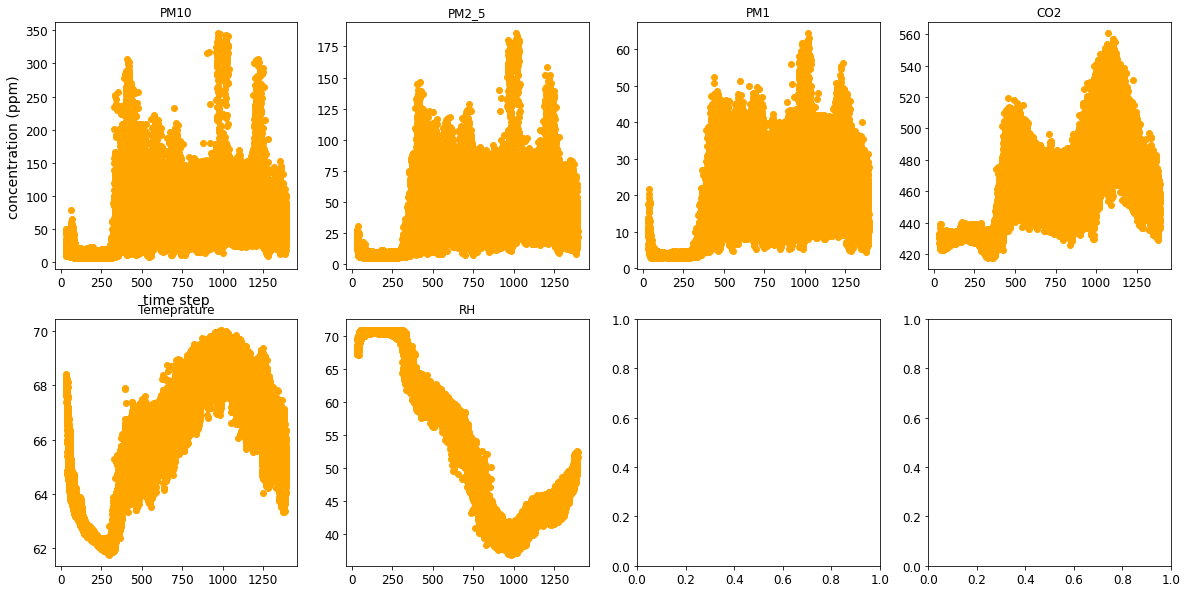

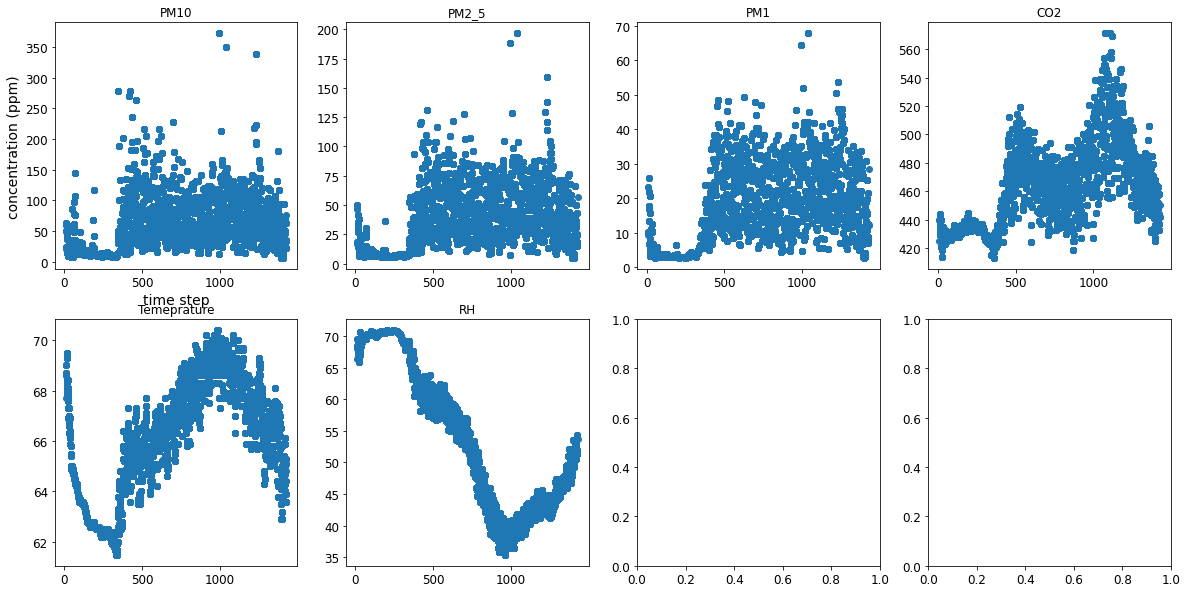

In [16]:
#generated data
#n_instances = 140
#noise = tf.random.normal([n_instances, latent_space])
generated_image = decoder(encoder(X_train_concat, training=False))
print(generated_image.shape)


generated_image = generated_image.numpy()
generated_image = generated_image.reshape(X_train_concat.shape[0]*ntimes, n_features)
generated_image = scaler.inverse_transform(generated_image)

fig, ax = plt.subplots(2,4, figsize=[20,10])

for i, group in enumerate(groups):
    ax.flatten()[i].plot(generated_image[:,0],generated_image[:,i+1],'o',c='orange')
    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")
    
plt.savefig('./output/Figures/Result/result'+notebookName+'_v'+str(k)+'.png')
print('save generated image')

X_train_concat_flatten2 = X_train_concat.reshape(X_train_concat.shape[0]*ntimes, n_features).astype('float32')
X_train_concat_flatten2 = scaler.inverse_transform(X_train_concat_flatten2)


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_concat_flatten2[:,0],X_train_concat_flatten2[:,i+1],'o')
    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")    
    
plt.savefig('./output/Figures/Result/sample_v'+str(k)+'.png')



# Covariance: 

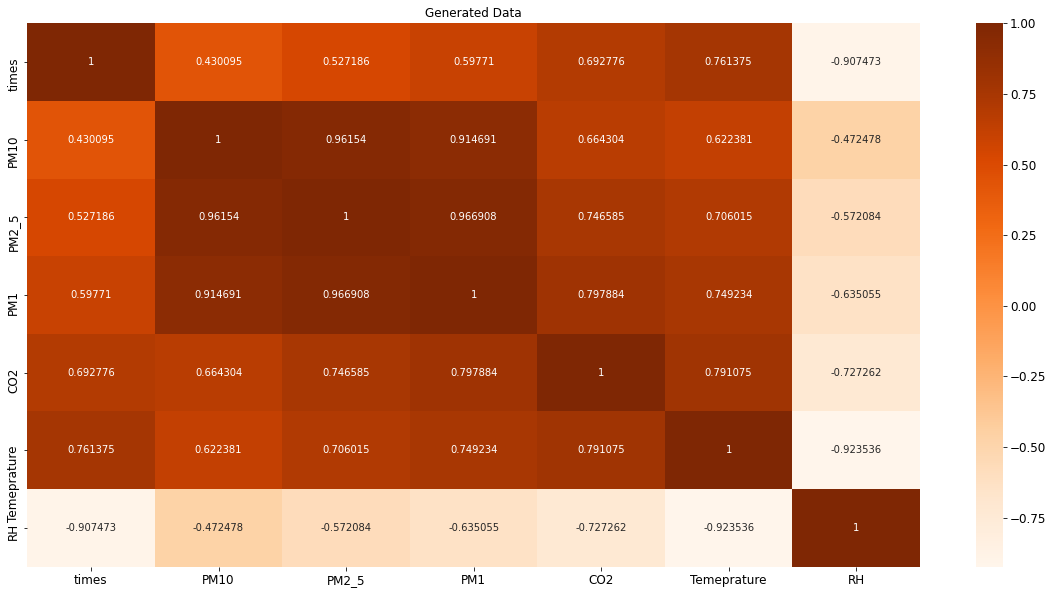

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns



data = np.array([generated_image[:,0],generated_image[:,1],generated_image[:,2],generated_image[:,3],generated_image[:,4],generated_image[:,5],generated_image[:,6]])
covMatrix = np.corrcoef(data)
fig, ax = plt.subplots(figsize=(20,10)) 

# create seabvorn heatmap with required labels
sns.heatmap(covMatrix, annot=True, fmt='g',cmap="Oranges", ax=ax, xticklabels=groups2, yticklabels=groups2)
plt.title('Generated Data')
plt.savefig('./output/Figures/Result/Covariance_generated_v'+str(k)+'.png')
plt.show()

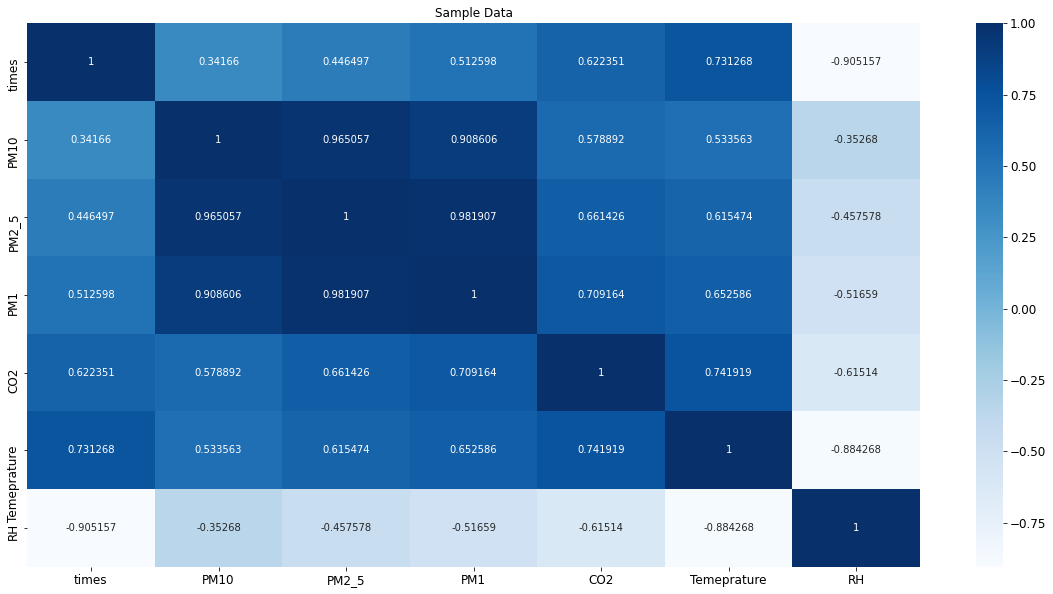

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#X_train_concat = X_train_concat.reshape(-1,7)

data = np.array([X_train_concat[:,0],X_train_concat[:,1],X_train_concat[:,2],X_train_concat[:,3],X_train_concat[:,4],X_train_concat[:,5],X_train_concat[:,6]])
covMatrix = np.corrcoef(data)
fig, ax = plt.subplots(figsize=(20,10)) 

# create seabvorn heatmap with required labels
sns.heatmap(covMatrix, annot=True, fmt='g',cmap="Blues", ax=ax, xticklabels=groups2, yticklabels=groups2)
plt.title('Sample Data')
plt.savefig('./output/Figures/Result/Covariance_sample_v'+str(k)+'.png')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

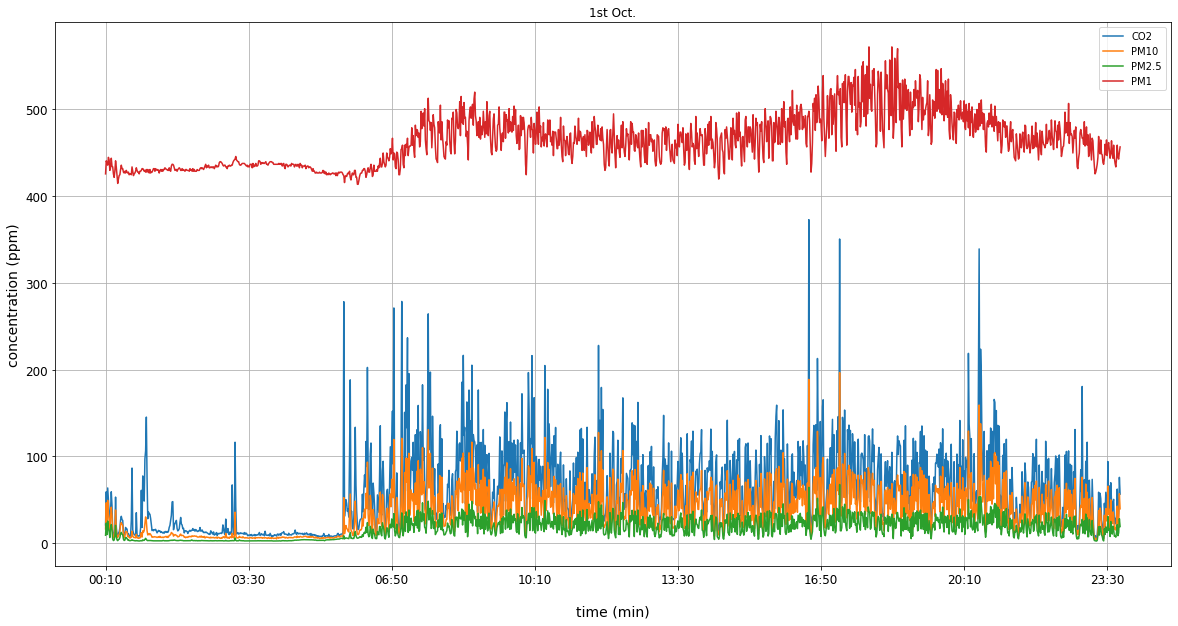

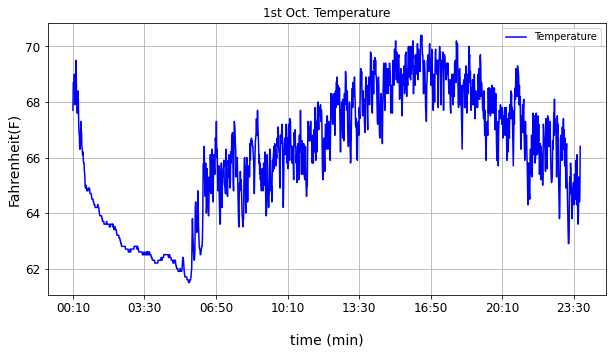

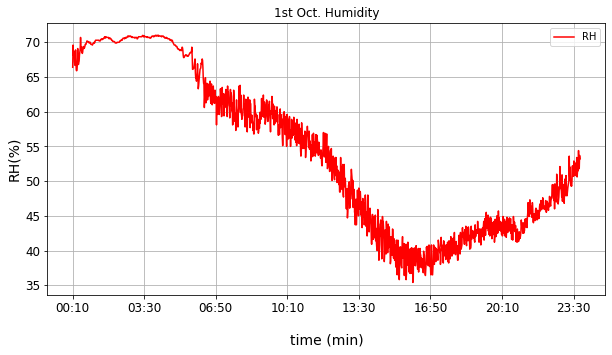

In [29]:
fig, ax = plt.subplots(1,1, figsize=[20,10]) 
ax.plot(times[:,0], data[:,1], label='CO2') 
ax.plot(times[:,0], data[:,2], label='PM10') 
ax.plot(times[:,0], data[:,3], label='PM2.5') 
ax.plot(times[:,0], data[:,4], label='PM1')

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)


ax.grid() 
plt.ylabel("concentration (ppm)") 
plt.xlabel("time (min)") 
plt.title('1st Oct.') 
plt.legend()
plt.savefig('./output/Figures/Sample_CO2+PM_01'+str(k)+'.png') 

fig, ax = plt.subplots(1,1, figsize=[10,5]) 
ax.plot(times[:,0], data[:,5],c='blue', label='Temperature') 

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)



ax.grid() 
plt.ylabel("Fahrenheit(F)") 
plt.xlabel("time (min)") 
plt.title('1st Oct. Temperature') 
plt.legend()
plt.savefig('./output/Figures/Sample_Temp_01'+str(k)+'.png') 

fig, ax = plt.subplots(1,1, figsize=[10,5]) 
ax.plot(times[:,0], data[:,6],c='red', label='RH') #what is the unit? 

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)


ax.grid() 
plt.ylabel("RH(%)") 
plt.xlabel("time (min)") 
plt.title('1st Oct. Humidity') 
plt.legend()

plt.savefig('./output/Figures/Sample_RH_01'+str(k)+'.png') 
plt.show

# Predict with the GAN

## Predict one point (start at n=0)

In [ ]:
notebookName = 'AAE-prediction.ipynb'

In [ ]:
n = 500
epochs = 10
epoch = 10000

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
def mse_loss(inp, outp):
    """
    Find the mean squared error of a prediction
 
    Parameters
    ----------
    inp : numpy.ndarray
       Generated values of the POD coefficients
    ontp : numpy.ndarray
       Real POD coefficients
 
    Returns
    -------
    float
        mean squared loss between inp and outp
    """
    inp = tf.reshape(inp, [-1, n_features])
    #print("inp: ", inp)
    outp = tf.reshape(outp, [-1, n_features])
    #print("outp:", outp)
    return mse(inp, outp)



def predict_coding(initial_pred, real_coding):
    loss = []
    for epoch in range(epochs):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output).numpy())
        initial_pred[:,(ntimes - 1):,:,-1] = decoder_output[:,(ntimes - 1):,:,-1]
        #initial_pred = decoder_output

    plt.plot(loss)
    plt.grid()
    plt.show
        
    return decoder_output,loss



real_coding = X_train_concat[n].reshape((1, ntimes, X_train_concat.shape[2],1))
print(real_coding.shape)


initial_pred = X_train_concat[n].reshape(1,-1)
initial_pred[:,n_features*(ntimes - 1):] = initial_pred[:,n_features*(ntimes - 2):n_features*(ntimes - 1)]
initial_pred = initial_pred.reshape((1, ntimes, X_train_concat.shape[2],1))
print(initial_pred.shape)


prediction_values,loss = predict_coding(initial_pred, real_coding)
print('Loss: ', loss[-1])

In [ ]:
X_generated = prediction_values.numpy()
X_generated = scaler.inverse_transform((X_generated.reshape(ntimes, n_features)))
print('X_generated : ',X_generated.shape)


#X_real = scaler.inverse_transform((X_train_concat[n].reshape(ntimes,n_features)))
#X_real = X_real.reshape(ntimes, n_features)
#print('X_real : ',X_train[n:(n+ntimes+predict_points,:].shape)



fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes),i+1], '-o', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/New/one_point_v'+str(k)+'_epoch_'+str(epoch)+'.png')

## Predict multiple points

**In this section we predict multiple points. We use the last predictions as the points to data assimilate in the next prediction** (start at n= 0)

epoch2 = epochs
n = 500
predict_points = 30

def predict_coding(initial_pred, real_coding):
    loss = []
    for epoch in range(epoch2):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output).numpy())
        initial_pred[:,(ntimes - 1):,:] = decoder_output[:,(ntimes - 1):,:]
    
    plt.plot(loss)
    plt.grid()
    plt.show

    return decoder_output,loss

real_coding = X_train_concat[n].reshape((1, ntimes, X_train_concat.shape[2],1))

initial_pred = X_train_concat[n].reshape(1,-1)
initial_pred[:,n_features*(ntimes - 1):] = initial_pred[:,n_features*(ntimes - 2):n_features*(ntimes - 1)]
initial_pred = initial_pred.reshape((1, ntimes, X_train_concat.shape[2],1))

prediction_values,loss = predict_coding(initial_pred, real_coding)

X_predict = list(prediction_values.numpy().reshape(-1,n_features))
gen_predict = prediction_values[:,(ntimes - 1):,:]


real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
initial_pred = real_coding
initial_pred[:,(ntimes - 1):,:] = initial_pred[:,(ntimes - 2):(ntimes - 1),:]

for i in range(predict_points):
    prediction_values,loss = predict_coding(initial_pred, real_coding)
    gen_predict = prediction_values[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    
    real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
    initial_pred = real_coding
    initial_pred[:,(ntimes - 1):,:,-1] = initial_pred[:,(ntimes - 2):(ntimes - 1),:,-1]
X_predict = np.array(X_predict)

X_generated2 = scaler.inverse_transform(X_predict)
X_generated2 = X_generated2.reshape(len(X_predict), n_features)
X_generated2[X_generated2<0] = 0 

print(X_generated2.shape) #

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated2[:,i+1], '-',c='orange', label='generated')
    #ax.flatten()[i].plot(X_real[:,i], '-o', label='real2')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/New/multiple_point'+'_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# Predict the whole simulation

### Start point = n = 0

In [ ]:
epoch2 = 2 #2000
epoch3 = 2 #2000
n = 500
print(X_train.shape)
predict_points = X_train.shape[0]-n-ntimes
print(predict_points)

In [ ]:
def predict_coding(initial_pred, real_coding):
    loss = []
    for epoch in range(epoch3):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output).numpy())
        initial_pred[:,(ntimes - 1):,:] = decoder_output[:,(ntimes - 1):,:]
    
    plt.plot(loss)
    plt.grid()
    plt.show

    return decoder_output,loss

real_coding = X_train_concat[n].reshape((1, ntimes, X_train_concat.shape[2],1))

initial_pred = X_train_concat[n].reshape(1,-1)
initial_pred[:,n_features*(ntimes - 1):] = initial_pred[:,n_features*(ntimes - 2):n_features*(ntimes - 1)]
initial_pred = initial_pred.reshape((1, ntimes, X_train_concat.shape[2],1))

prediction_values,loss = predict_coding(initial_pred, real_coding)

X_predict = list(prediction_values.numpy().reshape(-1,n_features))
gen_predict = prediction_values[:,(ntimes - 1):,:]
real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
initial_pred = real_coding
initial_pred[:,(ntimes - 1):,:] = initial_pred[:,(ntimes - 2):(ntimes - 1),:]

for i in range(predict_points):
    prediction_values,loss = predict_coding(initial_pred, real_coding)
    gen_predict = prediction_values[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
    initial_pred = real_coding
    initial_pred[:,(ntimes - 1):,:] = initial_pred[:,(ntimes - 2):(ntimes - 1),:]
X_predict = np.array(X_predict)

In [ ]:
X_generated3 = scaler.inverse_transform(X_predict)
X_generated3 = X_generated3.reshape(len(X_predict), n_features)
X_generated3[X_generated3<0] = 0 

print(X_generated3.shape) #

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated3[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated3[:,i+1], '-',c='orange', label='generated')
    #ax.flatten()[i].plot(X_real[:,i], '-o', label='real2')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/New/all'+'_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# All Day

In [ ]:
epoch3 = 2 #2000
n = 0
print(X_train.shape)
predict_points = X_train.shape[0]-n-ntimes
print(predict_points)

In [ ]:
def predict_coding(initial_pred, real_coding):
    loss = []
    for epoch in range(epoch3):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output).numpy())
        initial_pred[:,(ntimes - 1):,:] = decoder_output[:,(ntimes - 1):,:]
    
    plt.plot(loss)
    plt.grid()
    plt.show

    return decoder_output,loss

real_coding = X_train_concat[n].reshape((1, ntimes, X_train_concat.shape[2],1))

initial_pred = X_train_concat[n].reshape(1,-1)
initial_pred[:,n_features*(ntimes - 1):] = initial_pred[:,n_features*(ntimes - 2):n_features*(ntimes - 1)]
initial_pred = initial_pred.reshape((1, ntimes, X_train_concat.shape[2],1))

prediction_values,loss = predict_coding(initial_pred, real_coding)

X_predict = list(prediction_values.numpy().reshape(-1,n_features))
gen_predict = prediction_values[:,(ntimes - 1):,:]
real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
initial_pred = real_coding
initial_pred[:,(ntimes - 1):,:] = initial_pred[:,(ntimes - 2):(ntimes - 1),:]

for i in range(predict_points):
    prediction_values,loss = predict_coding(initial_pred, real_coding)
    gen_predict = prediction_values[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
    initial_pred = real_coding
    initial_pred[:,(ntimes - 1):,:] = initial_pred[:,(ntimes - 2):(ntimes - 1),:]
X_predict = np.array(X_predict)

In [ ]:
X_generated3 = scaler.inverse_transform(X_predict)
X_generated3 = X_generated3.reshape(len(X_predict), n_features)
X_generated3[X_generated3<0] = 0 

print(X_generated3.shape) #

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated3[:,i+1], '-',c='orange', label='generated')
    #ax.flatten()[i].plot(X_real[:,i], '-o', label='real2')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/New/allfrom0'+'_v'+str(k)+'_epoch_'+str(epoch)+'.png')